In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp

In [16]:
# 300, 900, 1800, 7200, 14400, 86400

period = '86400'
pair = 'USDT_XRP'
start = '1451606400' #jan2016
#start = '1483228800' #jan, 2017
#start = '1514764800' #jan, 2018
# start = '1543622400'
end = '9999999999'


URL = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'.format(pair, start, end, period)
chart = pd.read_json(URL)

In [17]:
chart['ema12'] = chart['close'].ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
chart['ema26'] = chart['close'].ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
chart['macd'] = chart['ema12'] - chart['ema26']
chart['signal'] = chart['macd'].ewm(span=9,min_periods=0,adjust=True,ignore_na=False).mean()

# chart['sma50'] = chart['close'].rolling(window=50,center=False).mean()
# chart['sma40'] = chart['close'].rolling(window=40,center=False).mean()
# chart['sma30'] = chart['close'].rolling(window=30,center=False).mean()

# chart['ema40'] = chart['close'].ewm(span=30,min_periods=0,adjust=True,ignore_na=False).mean()
# chart['ema30'] = chart['close'].ewm(span=30,min_periods=0,adjust=True,ignore_na=False).mean()


chart['ema20'] = chart['close'].ewm(span=20,min_periods=0,adjust=True,ignore_na=False).mean()
chart['sma30'] = chart['close'].rolling(window=30,center=False).mean()
chart['trend'] = chart['ema20'] - chart['sma30']
chart['diff'] = chart['macd'] - chart['signal']


chart = chart[29:]

chart.tail()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,ema12,ema26,macd,signal,ema20,sma30,trend,diff
1139,0.303300,2019-02-13,0.313100,0.301588,0.304000,2.021420e+06,623578.603269,0.308485,0.304851,0.310207,-0.005356,-0.006898,0.307479,0.309751,-0.002272,0.001542
1140,0.301449,2019-02-14,0.305074,0.299913,0.304114,6.639437e+05,201230.137427,0.303083,0.304328,0.309558,-0.005231,-0.006565,0.306905,0.309146,-0.002242,0.001334
1141,0.301552,2019-02-15,0.306000,0.298254,0.301012,7.198282e+05,217465.441335,0.302107,0.303900,0.308965,-0.005065,-0.006265,0.306395,0.308347,-0.001952,0.001200
1142,0.300040,2019-02-16,0.303568,0.300040,0.301665,1.941764e+05,58570.566690,0.301636,0.303307,0.308304,-0.004997,-0.006011,0.305790,0.307567,-0.001778,0.001014
1143,0.300802,2019-02-17,0.306790,0.298623,0.300054,5.561555e+05,168657.016402,0.303255,0.302921,0.307748,-0.004827,-0.005774,0.305315,0.306919,-0.001604,0.000947


In [4]:
size = chart.date.count()
order = [] # [price, amount]
asset = 1000
history = [1000]
growth = []
fee = 0.998

for i in range(size):
    entry = chart.iloc[i]
    price = entry['weightedAverage']
    
    if entry['trend'] < 0:
        if order:
            asset += (order[1] * price)
            gain = (asset / history[-1])
            history.append(asset)
            growth.append(gain)
            order = []
    else:
        if not order:
            if entry['diff'] > 0:
                amount = (asset / price)
                order = [price, amount]
                asset = asset - (price * amount)
        else:
            if entry['diff'] < 0:
                asset += (order[1] * price)
                gain = (asset / history[-1])
                history.append(asset)
                growth.append(gain)
                order = []

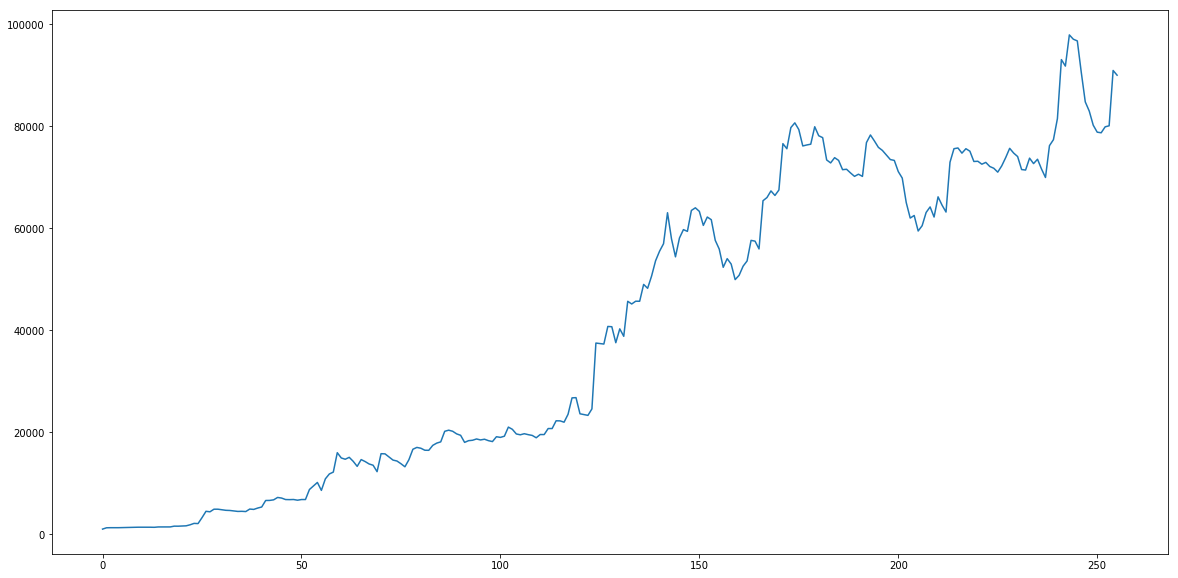

In [5]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.plot(history)
plt.show()

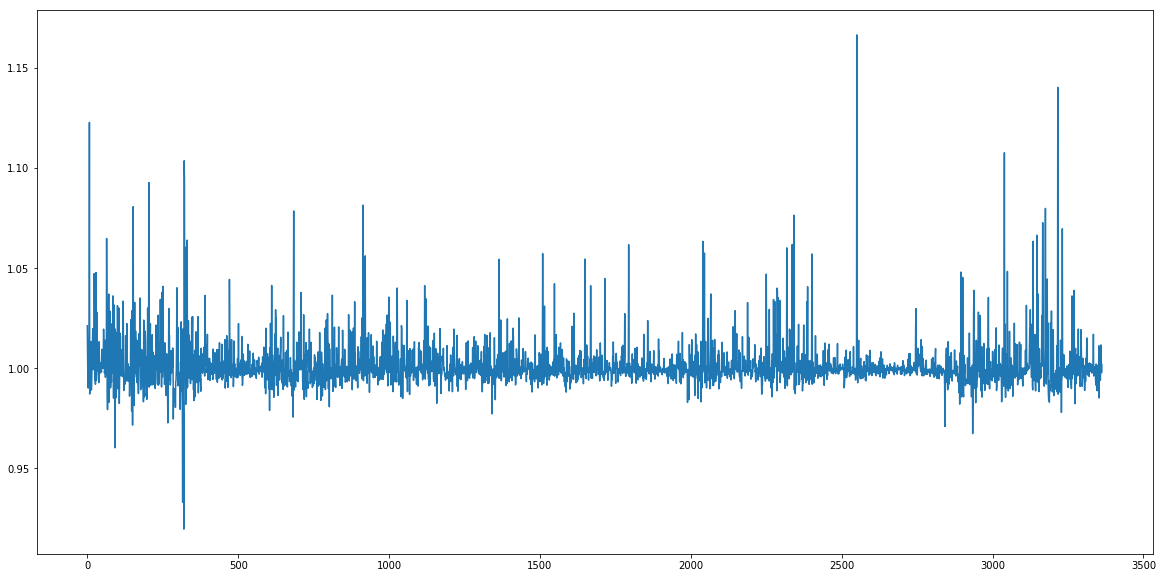

In [33]:
plt.plot(growth)
plt.show()

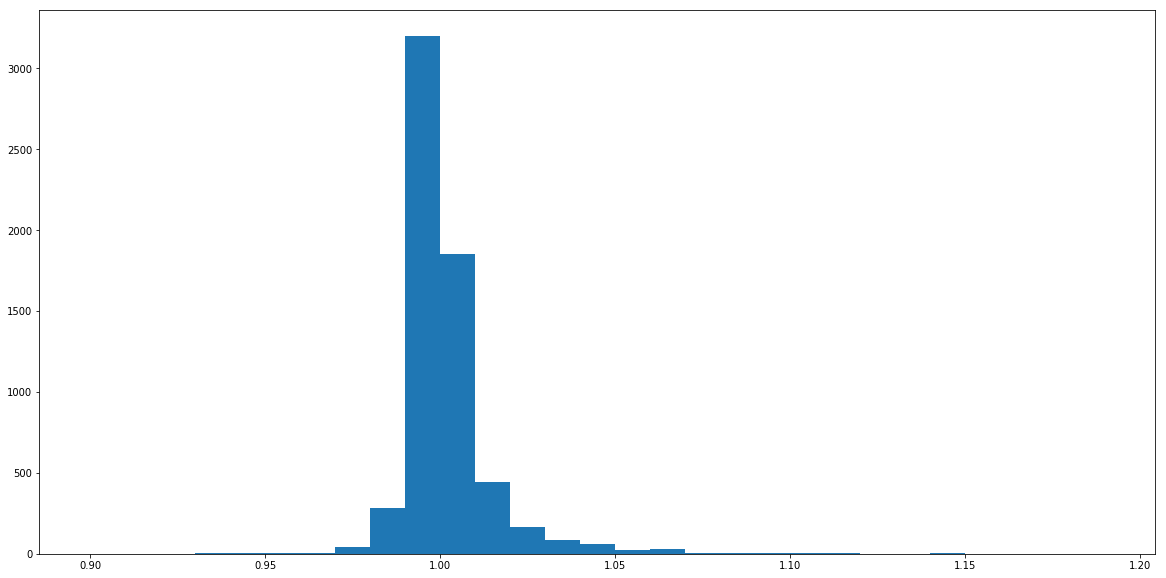

In [20]:
b = [(x/100) for x in range(90, 120, 1)]
plt.hist(growth, b)
plt.show()

In [34]:
result = 1
for i in growth:
    result *= i
    
result

40.69824240029389

In [7]:
# SHORT

size = chart.date.count()
order = [] # [price, amount]
asset = 10
history = [10]
growth = []
fee = 0.998


for i in range(size):
    entry = chart.iloc[i]
    price = entry['weightedAverage']
    
    if entry['trend'] > 0:
        if order:
            asset += (order[0] / price)
            gain = (asset / history[-1])
            history.append(asset)
            growth.append(gain)
            order = []
    else:
        if not order:
            if entry['diff'] < 0:
                amount = (asset * price)
                order = [amount]
                asset = 0
        else:
            if entry['diff'] > 0:
                asset += (order[0] / price)
                gain = (asset / history[-1])
                history.append(asset)
                growth.append(gain)
                order = []

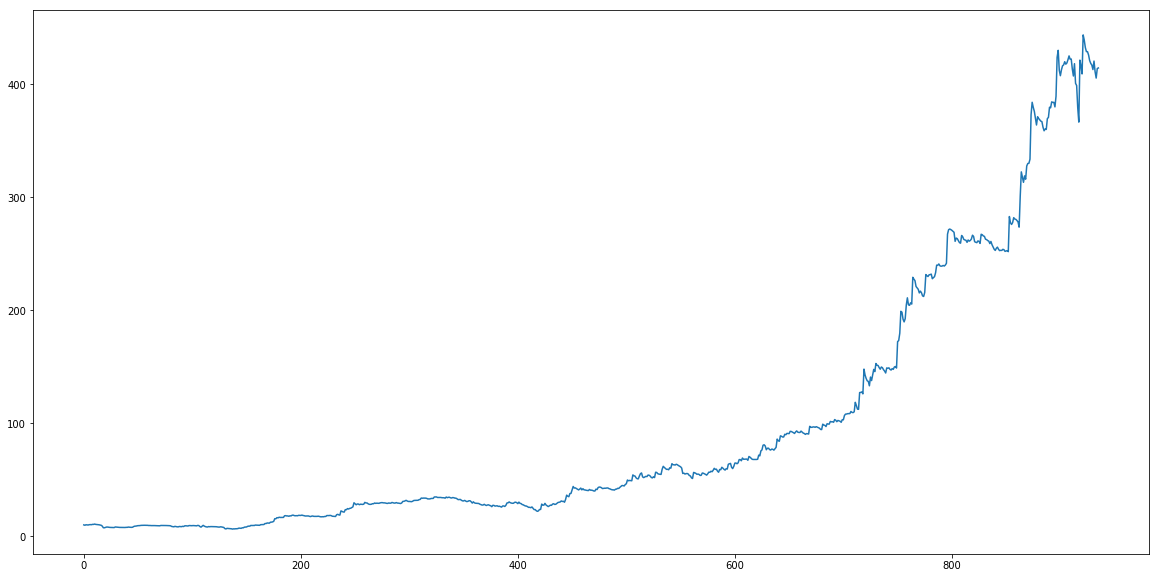

In [6]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.plot(history)
plt.show()

In [8]:
result = 1
for i in growth:
    result *= i
    
result

41.44643255759962

In [18]:
# new correction method

size = chart.date.count()
order = [] # [price, amount]
asset = 1
history = [1]
growth = []

method = 0

fee = 0.998

for i in range(size):
    entry = chart.iloc[i]
    price = entry['open']
    
    if method == 1:
        amount = (asset / price) * fee
        order = [price, amount]
        asset = 0
        method = 0

    if method == -1:
        asset += (order[1] * price) * fee
#         gain = (asset / history[-1])
        history.append(asset)
#         growth.append(gain)
        order = []
        method = 0

    else:
        if entry['trend'] < 0:
            if order:
                method = -1
        
        if entry['trend'] > 0:
            if not order:
                if entry['diff'] > 0:
                    method = 1
            else:
                if entry['diff'] < 0:
                    method = -1

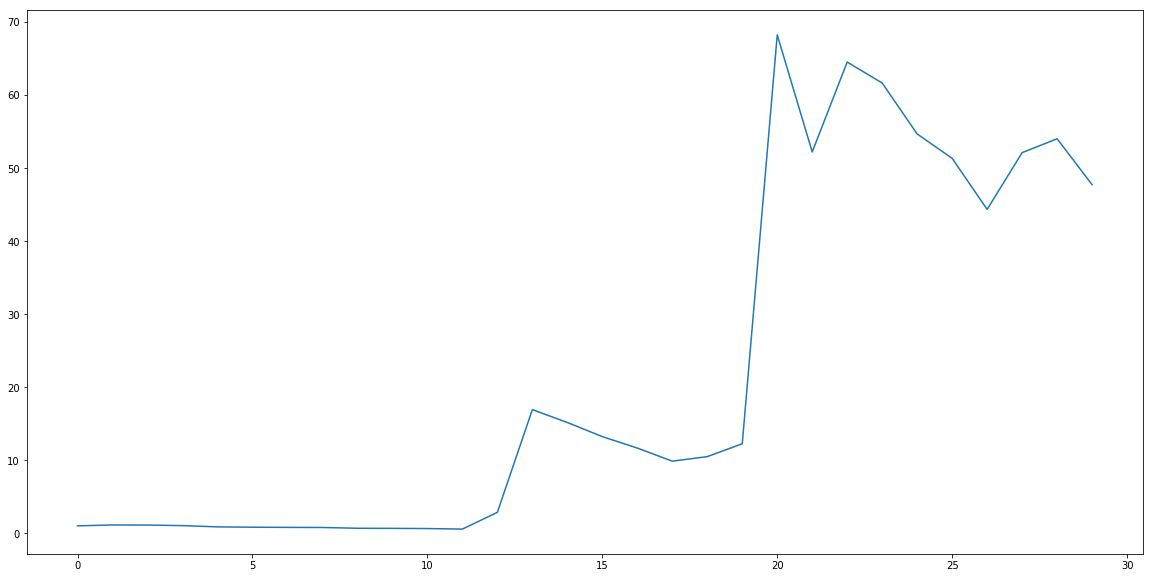

In [19]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.plot(history)
plt.show()